In [1]:
import sys, pickle
sys.path.append('../src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.stats import permutation_test
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from utils import lognormal_gen, generate_matrix
from visualization import *

## Preparations

In [2]:
rng = np.random.default_rng()
RESULT_DIR = '../results/'
AUD_MAP_TYPE, HVC_COND = 'neighbor', 'mature_hvc'
IMG_DIR = '../svg/different_models/'
# AUD_MAP_TYPE in ('neighbor', 'gaussian', 'discrete')
# HVC_COND in ('mature_hvc', 'developing_hvc')

### Constants

In [3]:
NE, NI, N_HVC = 600, 150, 15
PEAK_RATE, KERNEL_WIDTH = 150, 20
tauE, tauI, dt = 30, 10, 1

# EI transfer function parameters
rEmax, rImax, thE, thI, slope = 100, 100, 0, 0, 2

### Read and map auditory inputs

In [4]:
fname = '../realistic_auditory_processing/learned_song_responses.npz'
ma = 1/100 if AUD_MAP_TYPE=='discrete' else None
aud_real, mapping = read_realistic_input(fname, NE, mean=0, scale=2, 
                                         mapping=AUD_MAP_TYPE, mapping_args=ma)

### Constants

In [5]:
# Time window of perturbation
PERT_T0 = int(np.round(aud_real['pert_t0'].min(), -1))
PERT_T1 = int(np.round(aud_real['pert_t1'].max(), -1)) + 100

T_post = 200 # Silence after song
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
N_rend = 35 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

gen = lognormal_gen
c = 0.5
srKEc, srKIc = np.sqrt(NE*c), np.sqrt(NI*c)
JEE0, JEI0, JIE0, JII0 = np.array([1/srKEc, 1.7/srKIc, 1/srKEc, 1.5/srKIc]) / 10
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1

_ = np.arange(N_rend)
# (N_HVC, N_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
save_W_ts = np.round(burst_ts[-1]+KERNEL_WIDTH).astype(int)

w0_mean, w0_std, cW = 1/N_HVC, 0, 0.05

### Main

In [6]:
T_pre = 100 # time period to keep before song
N_test_rend = 20
T_test = T_burn + T_rend # Total
cases = ('ctrl', 'pert', 'deaf')
res = {k: [np.zeros((N_test_rend,T_pre+T_rend,NE+i)) for i in (0,NI,NI,NI)] for k in cases} 

# Init auditory for training
aud, _ = generate_realistic_aud(aud_real['ctrl'], N_rend, T_burn, T_post)

# Init HVC
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, PEAK_RATE+_*0.1, KERNEL_WIDTH+_*0.01)

# Init weights
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=True)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=True)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=True)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=True)

# Init models
net_FF = WCNet(NE, N_HVC, w0_mean, (rEmax, thE+5, slope), tauE, 
               w0_std=w0_std, cW=cW)
net_HVC2E = EINet(NE, NI, N_HVC, w0_mean, (rEmax, thE+3, slope), 
                  (rImax, thI, slope), tauE, tauI, 
                  JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                  w0_std=w0_std, cW=cW)
net_E2E = EINet(NE, NI, N_HVC, w0_mean, (rEmax, thE, slope), (rImax, thI, slope), tauE, tauI, 
                JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                w0_std=w0_std, cW=cW)
net_E2I = EINet(NE, NI, N_HVC, w0_mean, (rEmax, thE, slope), (rImax, thI, slope), tauE, tauI, 
                JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                w0_std=w0_std, cW=cW)

hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)

with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
    # Training
    plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-3e-2, 
                             tauW=1e5, asyn_H=10, rE_th=1.5, no_progress_bar=True)
    rE_FF, rI, Ws_FF, _, _ = net_FF.sim(hE0, rH, aud, save_W_ts, T, dt, 0.1, **plasticity_kwargs)
    
    plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-3e-2), 
                             tauW=1e5, asyn_H=10, rE_th=1.5, no_progress_bar=True)
    rE_HVC2E, rI, Ws_HVC2E, _, _ = net_HVC2E.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0.1, 
                                                 **plasticity_kwargs)

    plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-5e-2),
                         tauW=1e5, JEE0_mean=JEE0, asyn_E=10, rE_th=1.5, no_progress_bar=True)
    rE_E2E, rI, Ws_E2E, _, _ = net_E2E.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0.1, 
                                           **plasticity_kwargs)
    
    plasticity_kwargs = dict(plasticity=dict(JEI=bilin_hebb_EI,JIE=bilin_hebb_IE), 
                             lr=dict(JEI=5e-2,JIE=6e-3), tauW=1e5, 
                             JEI0_mean=JEI0, JIE0_mean=JIE0, 
                             asyn_E=10, asyn_I=0, rE_th=1.5, rI_th=5, no_progress_bar=True)
    rE_E2I, rI, Ws_E2I, _, _ = net_E2I.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0.1, 
                                           **plasticity_kwargs)

    # Init auditory for testing
    args = (N_test_rend, T_burn, T_post, None, False)
    aud_ctrl, aud_ctrl_idx = generate_realistic_aud(aud_real['ctrl'], *args)
    aud_pert = generate_realistic_aud(aud_real['pert'], *args)[0]

    # testing
    for k, a in zip(cases, (aud_ctrl, aud_pert, aud_ctrl*0)):
        for i in range(a.shape[0]): # for each case, enumerate over songs
            args = dict(rH=rH[:T_test], aud=a[i], save_W_ts=[], T=T_test, dt=dt, 
                        noise_strength=1, no_progress_bar=True)
            res[k][0][i] = np.hstack(net_FF.sim(hE0, **args)[:1])[T_burn-T_pre:]
            res[k][1][i] = np.hstack(net_HVC2E.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]
            res[k][2][i] = np.hstack(net_E2E.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]
            res[k][3][i] = np.hstack(net_E2I.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]

Not a recurrent model and rI will not be calculated.


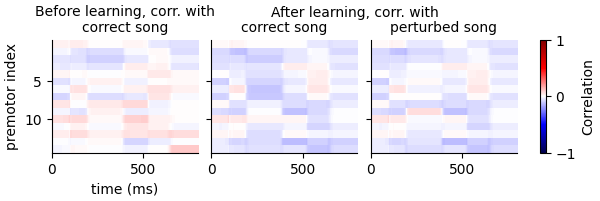

In [7]:
fig, ax = plot_corr_mat(Ws_HVC2E['HVC'], aud_real['ctrl'].mean(axis=0).T, 
                        aud_real['pert'].mean(axis=0).T,
                        ylabel='premotor index', yticks=[5, 10], xlabel='time (ms)')
fig.savefig(os.path.join(IMG_DIR, 'sparseW_EI_learn_res.svg'))

In [8]:
res_trial_avg, res_time_avg_trial_avg, res_time_avg_trial_se = {}, {}, {}
for k in cases:
    res_trial_avg[k], res_time_avg_trial_avg[k], res_time_avg_trial_se[k] = [], [], []
    for data in res[k]: # data is (trials, time, neurons)
        data = data - data[:,:T_pre].mean(axis=1, keepdims=True) # baseline correct
        res_trial_avg[k].append(data.mean(axis=0)) # (time, neurons)

        data = data[:,T_pre:T_pre+T_song].mean(axis=1) # focus on song period
        res_time_avg_trial_avg[k].append(data.mean(axis=0)) # (neurons,)
        res_time_avg_trial_se[k].append(data.std(axis=0) / np.sqrt(data.shape[0]))

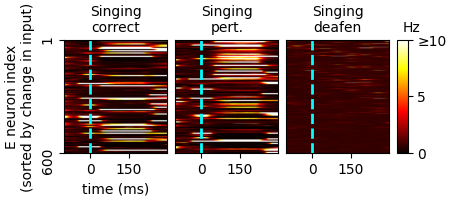

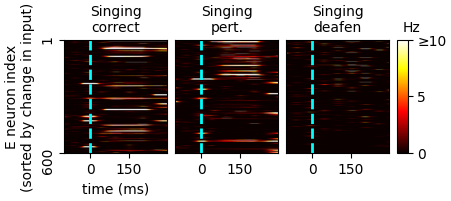

In [9]:
i = 0
titles = ['Singing\ncorrect', 'Singing\npert.', 'Singing\ndeafen']
syl = aud_real['ctrl'][:,:,PERT_T0:PERT_T1].mean(axis=(0,2))
for l, m in enumerate(('FF', 'EI')):
    _ = [res[k][l][i,:,:NE] for k in ('ctrl', 'pert', 'deaf')]
    t0, t1 = int(aud_real['pert_t0'][i]) + T_pre, int(aud_real['pert_t1'][i]) + T_pre
    bos_ctrl = aud_real['ctrl'][i,:,t0:t1].mean(axis=1)
    bos_pert = aud_real['pert'][i,:,t0:t1].mean(axis=1)
    err = [bos_ctrl - syl, bos_pert - syl, -syl]
    fig, ax = plot_raster_cmp_syl_dsyl(_, titles, syl, err, t0, t1+250, figsize=(4.5, 2), 
                                       sort_by='e', th=10, tpre=100) 
    for j in range(len(ax)-1):
        ax[j].set(xticks=[100, 250], xticklabels=[0, 150], xlabel='')
    ax[0].set(xlabel='time (ms)')
    fig.savefig(os.path.join(IMG_DIR, 'sparseW_premotor2E_err_response_%s.svg' % m))

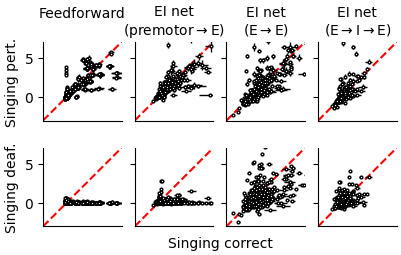

In [10]:
test_names = dict(pert='Singing pert.', deaf='Singing deaf.')
model_names = ('Feedforward\n', 'EI net\n(premotor$\\to$E)', 
               'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)')

fig, ax = plot_ctrl_vs_nonctrl(res_time_avg_trial_avg, res_time_avg_trial_se, 
                               test_names, model_names, figsize=(4,2.5))
fig.savefig(os.path.join(IMG_DIR, 'sparseW_premotor2E_learn_real_joint_dist.svg'), dpi=300)

In [11]:
model_names = ('Feedforward\n', 'EI net\n(premotor$\\to$E)', 
               'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)')
dist = wasserstein_distance_exp_vs_model(res_time_avg_trial_avg, model_names)

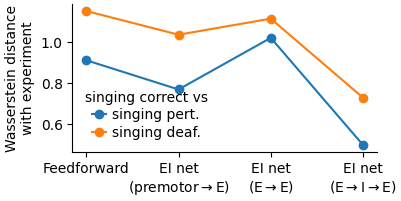

In [12]:
test_names = dict(pert='singing pert.', deaf='singing deaf.')
model_names = ('Feedforward\n', 'EI net\n(premotor$\\to$E)', 
               'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)')
fig, ax = plt.subplots(1, figsize=(4,2))
for k, d in dist.items():
    ax.plot(d, marker='o', label=test_names[k])
ax.set(ylabel='Wasserstein distance\nwith experiment')
ax.set(xticks=[0,1,2,3], xticklabels=model_names)
ax.legend(title='singing correct vs')
fig.savefig(os.path.join(IMG_DIR, 'wasserstein_sparseW.svg'), dpi=300)